# Clara Train SDK Performance Comparisons For Segmentation Problem

Clara Train SDK comes with many features that can accelerate model training speeds. This notebook will go through these features and showcase how they impact training speeds for a spleen segmentation problem. This tutorial assumes that the notebook is being run from spleen MMAR within the Clara Train docker.

This notebook will work through the following performance optimizations each building on the one before:<br>
1. [A baseline run](#baseline)
2. [Batch By Transform (BT)](#batchByTransofm)
3. [Smart Cache](#smart_cache)
4. [Batch By Transform + Smart Cache TrainV2](#BT_cacheV2)
5. [Batch By Transform + Smart Cache](#BT_cache)
6. [Multi-GPU training](#four_gpu) 

This notebook will replicate results shown below with different configurations showing speedups up to 50x
<br>![speed](screenShots/SpleenSummary.png)


## Prerequisites
- Familiarity with Clara Train main concepts. See [Getting Started Notebook](../GettingStarted/GettingStarted.ipynb)
- Familiarity with Clara Train performance main concepts. See [Performance Notebook](Performance.ipynb)
- Downloaded spleen segmentation dataset. Follow [Data Download Notebook](../../Data_Download.ipynb)
- Having multiple GPUs is preferred   


### Resources
You may watch the GTC Digital 2020 talks covering Clara Train SDK 
- [S22563](https://developer.nvidia.com/gtc/2020/video/S22563)
Clara train Getting started: cover basics, BYOC, AIAA, AutoML 
- [S22717](https://developer.nvidia.com/gtc/2020/video/S22717)
Clara train Performance: Different aspects of acceleration in train V3


## GPU Dashboard

This notebook comes with an extension called NVDashboard for displaying GPU utilization etc inside jupyter notebooks. 
For more info please see https://github.com/rapidsai/jupyterlab-nvdashboard. This extension is already installed. 
From the left sidebar, please click on the third tab (System dashboards) and click on GPU Utilization and GPU Memory. 
Then you can drag the tab to the right side of screen to display these along with training performance.


## DataSet 
The spleen segmentation task in this notebook performs volumetric (3D) segmentation 
of the spleen from CT images. The dataset used is Task09_Spleen.tar from 
the [Medical Segmentation Decathlon](http://medicaldecathlon.com/). 
Prior to running this notebook the data should be downloaded following 
the steps in [Data Download Notebook](../../Data_Download.ipynb).



# Lets get started
Before we get started lets check that we have an NVIDIA GPU available in the docker by running the cell below. 
For some portions of the notebook we will need to have 4GPUs available.


In [ ]:
# following command should show all gpus available 
!nvidia-smi

In [ ]:
# Run some imports and functions used in the notebook

# Import some of the libraries that we will use throughout this notebook.
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
# setting up MMAR root path
MMAR_ROOT="/claraDevDay/Performance/"
print ("MMAR_ROOT is set to ",MMAR_ROOT)
!ls $MMAR_ROOT
!chmod 777 $MMAR_ROOT/commands/*


In [ ]:
# Run some imports and functions used in the notebook

import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
def printFile(filePath,lnSt,lnOffset):
    print ("showing ",str(lnOffset)," lines from file ",filePath, "starting at line",str(lnSt))
    lnOffset=lnSt+lnOffset
    !< $filePath head -n "$lnOffset" | tail -n +"$lnSt"


## Baseline performance (65 hours) <a id='baseline'></a>

By default, most of the features are turned off because each feature may require tweaking or user control. 
To demonstrate, we'll be using spleen MSD data to train a 3D segmentation model. Our default configuration is:
* 96,96,96 random crops for training.
* Transformations:
    - LoadNifti
    - ConvertToChannelsFirst
    - Resample to 1x1x1
    - ScaleIntensityRange
    - FastCrop
    - ScaleIntensityOscillation
* Single GPU.
* Adam Optimizer (available in Clara Train).
* UNet3D (available in Clara Train).

In [ ]:
confFile=MMAR_ROOT+"/config/trn_base.json"
# To show the pipeline
printFile(confFile,84,13)

In [ ]:
# showing the transformations
printFile(confFile,25,50)

Let's run the training. This is expected to take around **65** hours on Tesla V100.

In [ ]:
start = time.time()
! $MMAR_ROOT/commands/train_SpleenDS.sh trn_base.json 0
end = time.time()
baseline_time = end-start

## Batch by Transform (18.2 hours) <a id='batchByTransofm'></a>
Typically data is moved from disk to memory then a crop is selected with an augmentation, then data is thrown away. 
With Batch by transform we take multiple batches from the same volume. 
Here, the important things to change are:
- The pipeline:
    - Name `SegmentationImagePipeline` 
    - The pipeline parameter `batch_by_transform:true` as
- selecting one of the batching transforms (`CropByPosNegRatio`, `FastCropByPosNegRatio`, `CropByPosNegRatioLabelOnly` ) 
and set the batch_size


In [ ]:
confFile=MMAR_ROOT+"/config/trn_BT.json"
# To show the pipeline
printFile(confFile,86,12)
# showing the batch by transform 
printFile(confFile,63,15)


Running cell below would run training 

In [ ]:
start = time.time()
! $MMAR_ROOT/commands/train_SpleenDS.sh trn_BT.json
end = time.time()
bt_time = end-start


## Smart Cache (9.6 hours) <a id='smart_cache'></a>

The first major step in training is data pre-processing. 
Our datasets are huge and data transformation can take a long time. 
To minimzie this overhead, one idea is to cache result of transformation chain and use it for training instead. 
However, we have to be careful to only cache results that are deterministic. 
Non-deterministic transforms like **RandomRotate** still need to be applied.

Here, the important things to change are:
- The pipeline:
    - Name `SegmentationImagePipelineWithCache` 
    - Setting parameter `batch_by_transform:false`
    - Setting parameter **`num_cache_objects`** and **`replace_percent`** as 

For more info on how smart cache works and these parameters, 
please see the [smart cache documentation](https://docs.nvidia.com/clara/tlt-mi/clara-train-sdk-v3.0/nvmidl/additional_features/smart_cache.html).


In [ ]:
confFile=MMAR_ROOT+"/config/trn_cache.json"
# To show the pipeline
printFile(confFile,84,12)
# showing the cropping transform 
printFile(confFile,63,15)

Let's run training and measure the performance using trn_cache.json

In [ ]:
start = time.time()
! $MMAR_ROOT/commands/train_SpleenDS.sh trn_cache.json 0
end = time.time()
cache_time = end-start


Note: Smart cache requires tuning its parameters to get the best performance.


## Smart Cache + Batch By transform as in Train V2 (9.6 hours) <a id='smart_cache'></a>

In Clara Train V2, we were able to use batch by transform in addition to caching. 
However, all batches would come for the same volume. This was done by:
- Use pipeline `SegmentationImagePipelineWithCache`
- Set `batch_by_transform = true`  
- Use one of the cropping transforms as `FastCropByPosNegRatio`


In [ ]:
confFile=MMAR_ROOT+"/config/trn_BT_cache_TrnV2.json"
# To show the pipeline
printFile(confFile,87,12)
# showing the cropping transorm 
printFile(confFile,64,15)

Let's run training and measure the performance using trn_cache.json

In [ ]:
start = time.time()
! $MMAR_ROOT/commands/train_SpleenDS.sh trn_BT_cache_TrnV2.json 0
end = time.time()
bt_cacheV2_time = end-start


## Smart Cache + Batch By transform (4.4 hours) <a id='smart_cache'></a>
We can combine smart cache and batch by transform by doing the following:
- Use pipeline `SegmentationImagePipelineWithCache`
- Set `batch_by_transform = false`
- Add a `batch_transforms` to merge extra dims
Note: Smart cache requires tuning its parameters to get the best performance.

In [ ]:
confFile=MMAR_ROOT+"/config/trn_BT_cache.json"
# To show batch_transforms section
printFile(confFile,96,12)
# showing the batch by transform 
printFile(confFile,64,15)
# To show the pipeline
printFile(confFile,86,8)


Let's run training and measure the performance using trn_cache.json

In [ ]:
start = time.time()
# !./train_cache.sh
! $MMAR_ROOT/commands/train_SpleenDS.sh trn_BT_cache.json 0
end = time.time()
bt_cache_time = end-start


## Multiple GPUs (1.5 hours)<a id='four_gpu'></a>

Now we can explore the power of multiple GPUs. Let's bump up the number of GPUs to 4 and see the improvement.

In [ ]:
start = time.time()
! $MMAR_ROOT/commands/train_NgpuSpleenDS.sh trn_novograd_4gpu.json
end = time.time()
four_gpu_time = end-start

As we can see, our training time has now reduced to only **1.5** hours.


Finally lets plot the results for all experiments we did. 
Cell below replace any missing/skipped experiment with our experiment numbers

In [1]:
try: baseline_time
except NameError: baseline_time = 233779

try: bt_time
except NameError: bt_time = 65385
    
try: cache_time
except NameError: cache_time = 34667
    
try: bt_cacheV2_time
except NameError: bt_cacheV2_time = 34408
    
try: bt_cache_time
except NameError: bt_cache_time = 15817
    
try: four_gpu_time
except NameError: four_gpu_time = 5486
    
    

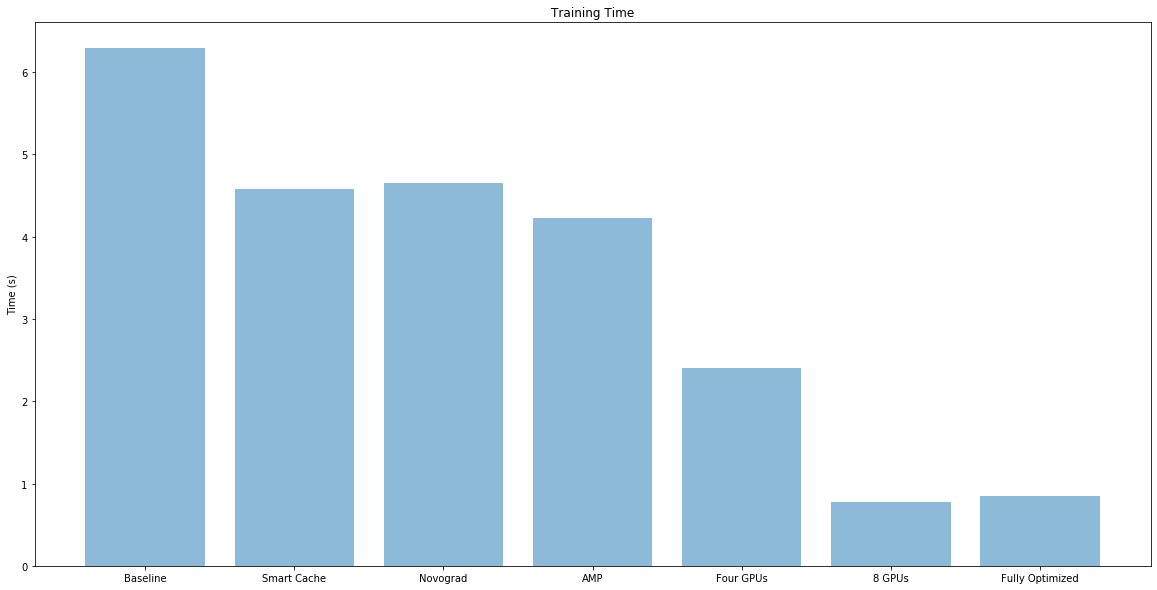

In [4]:
objects = ('Baseline', 'Batch By Trans', 'Cache', 'BT Cache V2', 'BT Cache V3', '4 GPUs')
y_pos = np.arange(len(objects))
performance = [baseline_time, bt_time, cache_time, bt_cacheV2_time,bt_cache_time, four_gpu_time]
convert_to_hours = 60*60
performance_hours = [t / convert_to_hours for t in performance]

plt.rcParams["figure.figsize"] = (20,10)
plt.bar(y_pos, performance_hours, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time (s)')
plt.title('Training Time')

plt.show()



# Exercise 

1. You should change batch size from 3x4 to 2x6 for batch by transform + cache 
running on 4 gpus to see a drop from 1.5 hrs to 1.2 hours

2. You could change config to enable Automatic Mixed Precision (AMP). 
Automatic Mixed precision is a technology that allows training with half-precision where possible thus maximizing training accuracy and performance. 
As an added benefit, the memory consumption can also be reduced. 
_Note_ that AMP is still a feature in development and continues to improve so your mileage may vary depending on what layers the model have. 
_Hint_ To activate AMP in our training set the following in your config
````
"use_amp": true
````
for example checkout [config/config_train_novograd_amp.json](config/config_train_novograd_amp.json)

3. You could try changing the optimizer to novograd optimizer from nvidia instead of Adam optimizer. 
NovoGrad converges faster hence reducing overall training time. 
It is available at https://github.com/NVIDIA/OpenSeq2Seq/blob/master/open_seq2seq/optimizers/novograd.py. 
we enable this by changing the optimizer to NovoGrad 
````
  "optimizer": {
    "name": "NovoGrad"
  },
````
_Hint_ you could checkout [config/trn_novograd.json](config/trn_novograd.json)
As we notice, the training time per epoch is mostly consistent with previous times. 
However, our model converges to best accuracy faster.

